In [ ]:
"""
CONVOLUTION ENCODER-DECODER FOR ART 

 Art images given in npy arrays


Modigliani_paintings.npy
Abstractblue.npy
NEURON128x128.npy

#image values are already normalized in [0 1]

libraries: 

!pip install opencv-python tensorflow keras numpy scikit-learn os torch torchvision torchaudio pillow


"""

In [ ]:

"""
load data set (IMAGE SIZE 128x128)

Modigliani_paintings.npy
AbstractPaintings_Dataset.npy

#image values are already normalized in [0 1]

"""

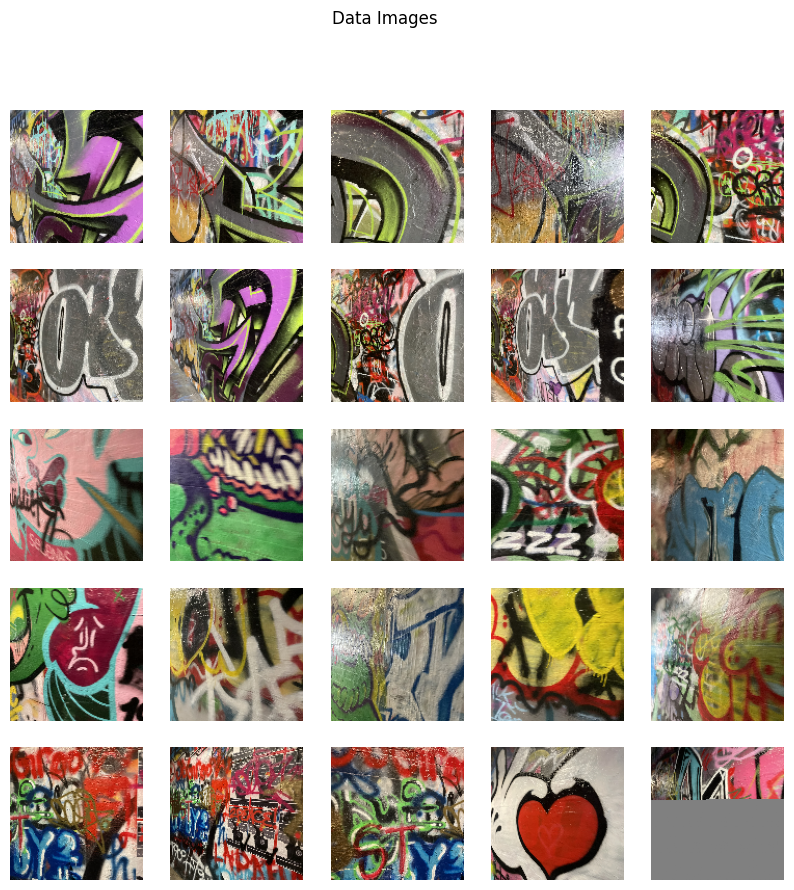

data loaded
training data saved


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Piet_Mondrian128x128.npy
#Gustav_Klimt128x128.npy
#Henri_Matisse128x128.npy 
#Jackson_Pollock128x128.npy 
#Pablo_Picasso128x128.npy


#data already normalized by 255, in the range [0 1]

#dataset shape: (num images, size, size, channels)
#data = np.load("NEURON128x128.npy")

data0 = np.load("Piet_Mondrian128x128.npy")
data1 = np.load("STUDENT_PHOTOS128x128.npy")
data3 = np.load("Abstractblue.npy")
data4 = np.load("Frida_Kahlo128x128.npy")
data5 = np.load("Andy_Warhol64x64.npy")  

data6 = np.load("Piet_Mondrian_geometric128x128.npy")
data7 = np.load("Jackson_Pollock128x128.npy")
data8 = np.load("Pablo_Picasso_faces128x128.npy")
data9 = np.load("FinalLightPaintingData128x128.npy")
data10 = np.load("Tunnel128x128.npy")
data11 = np.load("Butterfly128x128.npy")
data12 = np.load("Gabbiano_portrait64x64.npy")
data13 = np.load("Gabbiano_portrait128x128.npy")
data14 = np.load("STUDENT_PHOTOS128x128.npy")

# Step 1: Define the original filename and new filename
filename = "STUDENT_PHOTOS128x128"  # You can replace this with your desired name

# Step 2: Load the corresponding array from the original file
data = np.load(filename + ".npy")

#combine sets
#data = np.concatenate((data10,data11),axis=0)

num_samples, img_size, canc, channels = data.shape

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = data[i]
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
    ax.imshow(img)
    ax.axis("off")
    plt.suptitle("Data Images")

    
plt.savefig("AE-RBMdata_" + filename + ".png", format="png", dpi=300)  # Save as PNG
plt.savefig("AE-RBMdata_" + filename + ".eps", format="eps")  # Save as PDF
plt.savefig("AE-RBMdata_" + filename + ".pdf", format="pdf")  # Save as PDF
plt.savefig("AE-RBMdata_" + filename + ".tiff", format="tiff", dpi=300)  # Save as TIFF

plt.show()


print("data loaded")

data.shape


"""  
save training data in a numpy array that
     will be used by the main code

""" 

# choose filename to save the image data
np.save("training_images.npy", data)

print("training data saved")



In [ ]:
"""
ENCODER ARCHITECTURE


Input Image: (batch_size, 3, 128, 128)
After 1st Conv Layer: (batch_size, 64, 64, 64)
After 2nd Conv Layer: (batch_size, 32, 32, 32)
After 3rd Conv Layer: (batch_size, 16, 16, 16) (Latent space representation)
After 1st Transpose Conv Layer: (batch_size, 32, 32, 32)
After 2nd Transpose Conv Layer: (batch_size, 64, 64, 64)
After 3rd Transpose Conv Layer: (batch_size, 3, 128, 128) (Reconstructed image)

"""


using device: cuda
Epoch 2000/2000, Loss: 0.005796

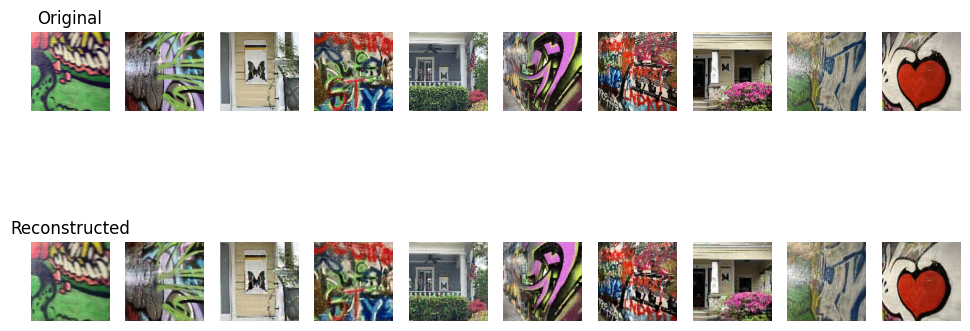

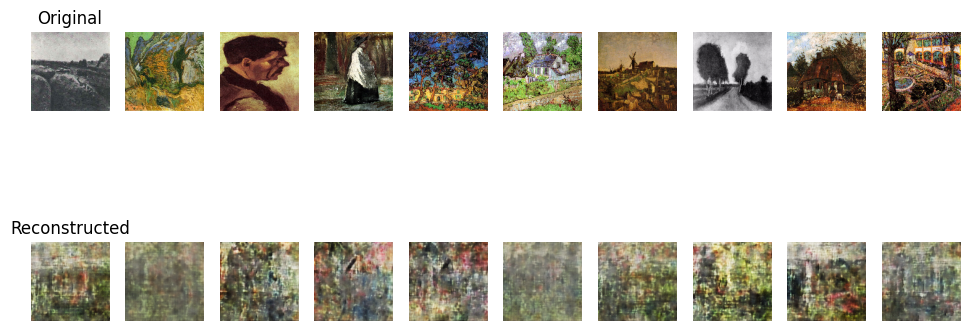

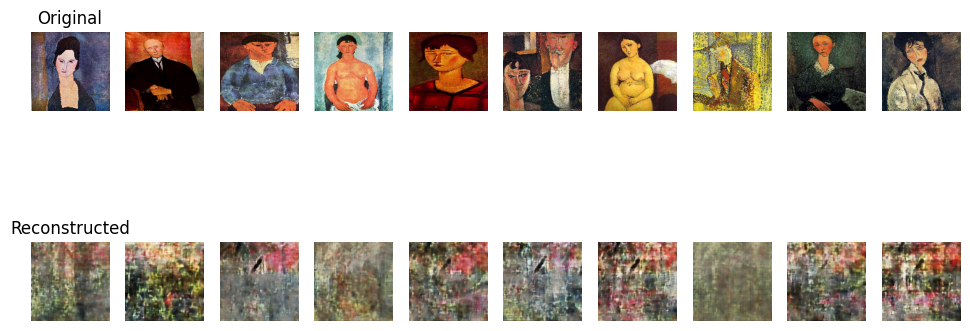

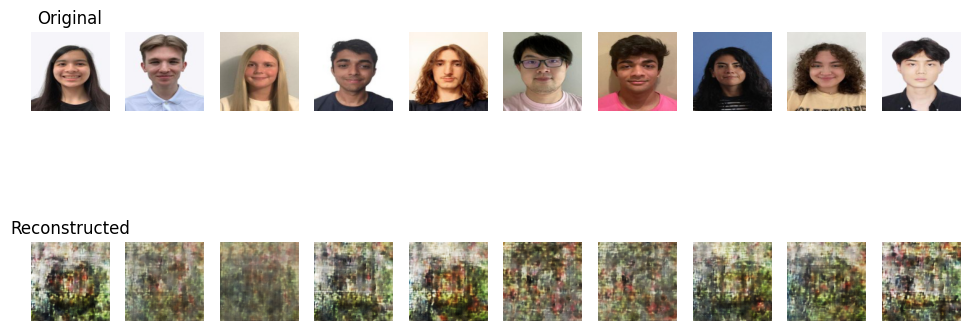

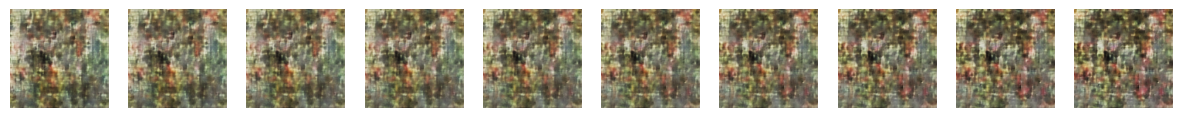

Saved latent vectors to latent_vectors.npy, shape: (43, 128)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("using device: " + str(device))


# --- 1. Define Dataset ---
class ArtDataset(Dataset):
    def __init__(self, images):
        self.images = images.astype(np.float32) #/ 255.0  # Normalize to [0,1]
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # Shape: (img_size, img_size, channels)
        img = self.transform(img)  # Convert to (C, H, W)
        return img

# --- 2. Define Convolutional Autoencoder ---
class ConvAutoencoder(nn.Module):
    def __init__(self, channels=3):
        super(ConvAutoencoder, self).__init__()
        # Encoder: Compress input into a smaller representation
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, stride=2, padding=1),   # Output: 64 channels
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),        # Output: 32 channels
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),        # Output: 16 channels (latent space)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*16*16, 128)  # Add bottleneck!
        )
        
        
        
        # Decoder: Expand latent space representation back to original input size
        self.decoder = nn.Sequential(
            nn.Linear(128, 16*16*16),
            nn.Unflatten(1, (16, 16, 16)),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # Increase to 32 channels
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # Increase to 64 channels
            nn.ReLU(),
            nn.ConvTranspose2d(64, channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output 3 channels (RGB)
            nn.Sigmoid()  # Sigmoid to scale outputs to [0, 1] for RGB images
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))
        #x = self.encoder(x)
        #x = self.decoder(x)
        #return x

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

# --- 3. Training Function ---
def train_autoencoder(model, dataloader, epochs=100, lr=0.001):
    criterion = nn.MSELoss()  #n.L1Loss()  SmoothL1Loss()  BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) #AdamW for sparsity 
    alpha = 0.001
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch in dataloader:
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch) + alpha * torch.mean(torch.abs(model.encode(batch))) # add L1 norm for sparsity
            #loss = criterion(outputs, batch) + alpha * torch.mean(torch.linalg.vector_norm(model.encode(batch),ord=2))
            #loss = 0.5 * nn.MSELoss()(output, target) + 0.5 * nn.L1Loss()(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f"\rEpoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}", end="", flush=True)

# --- 4. Load and Process Data ---
def load_images(image_array, batch_size=32):
    dataset = ArtDataset(image_array)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# --- 5. Testing Function (Visualizing Input-Output) ---
def test_autoencoder(model, dataloader, num_images):
    model.eval()
    images = next(iter(dataloader))[:num_images]  # Get first batch
    
    with torch.no_grad():
        reconstructed = model(images)

    images = images.numpy().transpose(0, 2, 3, 1)
    reconstructed = reconstructed.numpy().transpose(0, 2, 3, 1)
    
    fig, axes = plt.subplots(2, num_images, figsize=(12, 5))
    for i in range(num_images):
        axes[0, i].imshow(images[i])
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i])
        axes[1, i].axis('off')

    axes[0, 0].set_title("Original")
    axes[1, 0].set_title("Reconstructed")
    plt.show()

# --- Latent Space Interpolation ---
def interpolate_images(autoencoder, dataloader, steps=10):
    autoencoder.eval()  # Set model to evaluation mode
    
    images = next(iter(dataloader))[:2]  # Take two images
    with torch.no_grad():
        z1 = autoencoder.encoder(images[0].unsqueeze(0))  # Encode first image
        z2 = autoencoder.encoder(images[1].unsqueeze(0))  # Encode second image
    
    interpolated_images = []
    for alpha in np.linspace(0, 1, steps):
        z_interp = (1 - alpha) * z1 + alpha * z2  # Linear interpolation
        img_interp = autoencoder.decoder(z_interp).squeeze(0).permute(1, 2, 0).detach().numpy()
        interpolated_images.append(img_interp)

    # Plot the interpolation results
    fig, axes = plt.subplots(1, steps, figsize=(15, 5))
    for i in range(steps):
        axes[i].imshow(interpolated_images[i])
        axes[i].axis('off')

    plt.show()



# --- 6. Main Execution ---
if __name__ == "__main__":
    # Load images from file
    images_np = np.load('training_images.npy')
    dataloader = load_images(images_np, batch_size=16)
    
    autoencoder = ConvAutoencoder(channels=images_np.shape[-1])
    
    # Train model
    train_autoencoder(autoencoder, dataloader, epochs=2000, lr=0.0005)
    
    
    images_np = np.load("training_images.npy")
    dataloader = load_images(images_np, batch_size=32)
    # Test model
    test_autoencoder(autoencoder, dataloader, num_images=10)
    
    images_np = np.load("VanGogh.npy")
    dataloader = load_images(images_np, batch_size=32)
    # Test model
    test_autoencoder(autoencoder, dataloader, num_images=10)


    images_np = np.load("Modigliani_paintings.npy")
    dataloader = load_images(images_np, batch_size=32)
    # Test model
    test_autoencoder(autoencoder, dataloader, num_images=10)
    
    
    images_np = np.load("STUDENT_PHOTOS128x128.npy")
    dataloader = load_images(images_np, batch_size=28)
    # Test model
    test_autoencoder(autoencoder, dataloader, num_images=10)


    # Interpolation
    interpolate_images(autoencoder, dataloader)
    
    
    
    # --- Save latent vectors of all training images ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder.to(device)
    
    images_np = np.load('training_images.npy')  # Reload training images
    autoencoder.eval()  # Set model to evaluation mode
    
    # Convert all images to tensor and move to device
    images_tensor = torch.tensor(images_np.astype(np.float32)).permute(0, 3, 1, 2).to(device)  # Shape: (N, C, H, W)
    
    with torch.no_grad():
        latent_vectors = autoencoder.encode(images_tensor)  # Encode all images at once
    
    # Move to CPU and convert to numpy
    latent_vectors_np = latent_vectors.cpu().numpy()
    np.save("latent_vectors.npy", latent_vectors_np)  # Save to file
    print("Saved latent vectors to latent_vectors.npy, shape:", latent_vectors_np.shape)


In [3]:
"""SAVE LATENT VECTORS OF THE TRAINING IMAGES IN NPY ARRAY"""

# --- Save latent vectors of all training images ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

images_np = np.load('training_images.npy')  # Reload training images
autoencoder.eval()  # Set model to evaluation mode
    
    # Convert all images to tensor and move to device
images_tensor = torch.tensor(images_np.astype(np.float32)).permute(0, 3, 1, 2).to(device)  # Shape: (N, C, H, W)
    
with torch.no_grad():
    latent_vectors = autoencoder.encode(images_tensor)  # Encode all images at once
    
    # Move to CPU and convert to numpy
latent_vectors_np = latent_vectors.cpu().numpy()
np.save("latent_vectors.npy", latent_vectors_np)  # Save to file
print("Saved latent vectors to latent_vectors.npy, shape:", latent_vectors_np.shape)

Saved latent vectors to latent_vectors.npy, shape: (43, 128)


In [4]:
"""

RBM for latent vectors

""" 


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit



# Define stable sigmoid function
#def sigmoid(x):
#    return 1 / (1 + np.exp(-x))
def sigmoid(x):
    return expit(x)

def batch_normalize(v):
    mean = np.mean(v, axis=0, keepdims=True)
    std = np.std(v, axis=0, keepdims=True) + 1e-8  # Avoid division by zero
    return (v - mean) / std
    
    
# Initialize RBM parameters
class GaussianBernoulliRBM:
    def __init__(self, visible_units, hidden_units, learning_rate, sig):
        self.v_units = visible_units
        self.h_units = hidden_units
        self.lr = learning_rate
        self.sigma = sig
        
        # Initialize weights and biases
        self.W = np.random.randn(self.v_units, self.h_units) * 0.01  # Small random values
        self.b_v = np.zeros(self.v_units)  # Visible biases
        self.b_h = np.zeros(self.h_units)  # Hidden biases

    # Forward pass: Sample hidden states given visible states
    def sample_hidden(self, v):
        h_mean = sigmoid( np.dot(v, self.W)/( (self.sigma) **2 ) + self.b_h )
        #h_sample = np.random.binomial(1, h_mean)  # Bernoulli sample
        h_sample = (np.random.uniform(size=h_mean.shape) < h_mean).astype(np.float32)
        return h_mean, h_sample

    # Backward pass: Sample visible states given hidden states
    def sample_visible(self, h):
        v_mean = np.dot(h, self.W.T) + self.b_v  # Gaussian visible layer
        v_sample = v_mean + self.sigma * np.random.randn(*v_mean.shape)  # Add Gaussian noise
        return v_mean, v_sample

        # Train RBM with Contrastive Divergence (CD-1) + save hidden variables
    def train(self, data, epochs, batch_size):
        num_samples = data.shape[0]
        error_list = []
        hidden_vars_list = []  # Store hidden variables for all images
    
        for epoch in range(epochs):
            np.random.shuffle(data)  # Shuffle data each epoch
            error = 0
            hidden_epoch = []  # Store hidden variables for the current epoch
    
            for i in range(0, num_samples, batch_size):
                v_0 = data[i:i+batch_size]  # Mini-batch
    
                # Positive phase
                h_0_mean, h_0_sample = self.sample_hidden(v_0)
    
                # Store hidden representations
                hidden_epoch.append(h_0_mean)
    
                # Negative phase (Reconstruct visible layer)
                v_k_mean, v_k_sample = self.sample_visible(h_0_sample)
                h_k_mean, _ = self.sample_hidden(v_k_sample)
    
                # Update weights and biases
                self.W += self.lr * (np.dot(v_0.T, h_0_mean) - np.dot(v_k_sample.T, h_k_mean)) / batch_size
                self.b_v += self.lr * np.mean(v_0 - v_k_sample, axis=0)
                self.b_h += self.lr * np.mean(h_0_mean - h_k_mean, axis=0)
    
                error += np.mean(np.mean(np.abs(v_0 - v_k_mean), axis=0))
    
            print(f"\rEpoch {epoch+1}/{epochs} completed, error={error}", end=" ")
    
            error_list.append(error)
            hidden_vars_list.append(np.vstack(hidden_epoch))  # Stack batch results
    
        return error_list, np.vstack(hidden_vars_list)  # Return hidden variables for all images
 
    
    # Generate samples from the trained RBM
    def generate_samples(self, num_samples, steps):
        v = np.random.randn(num_samples, self.v_units)  # Random initialization

        for _ in range(steps):  # Gibbs Sampling
            h_mean, h_sample = self.sample_hidden(v)
            v_mean, v = self.sample_visible(h_sample)

        return v_mean, h_mean # Return final generated visible samples and hidden variables 

"""
# main 
#data = np.load("VanGogh.npy")
#dataset shape:(855, 64, 64, 3)
#data already normalized by 255, in the range [0 1]
"""

hidden_size = 32 # number of hidden variables 

data = np.load("latent_vectors.npy")
num_samples, img_size = data.shape

data_flat = data.reshape(num_samples, -1) #Array  num_samples x img_size^2


# Normalize to mean 0 and variance 1
mean = data_flat.mean(axis=0)  # Compute the mean along the first axis (samples)
std = data_flat.std(axis=0)  # Compute the standard deviation along the first axis (samples)

# Standardize the data
data_flat = (data_flat - mean) / std

# Normalize images to [-1,1] for Gaussian-Bernoulli RBM
data_flat = (data_flat - 0.5) * 2  


print("start training")
# Train RBM on CBL Faces
rbm = GaussianBernoulliRBM(visible_units=img_size, hidden_units=hidden_size, learning_rate=0.025, sig=0.1)
rbm.train(data_flat, epochs=10000, batch_size=16)

# Generate and plot new face samples
generated_data, generated_hidden_var= rbm.generate_samples(num_samples=25, steps=50)

np.save("RBM_generated_latent_vectors.npy",generated_data)

generated_data.shape

print("data saved")

start training
Epoch 10000/10000 completed, error=2.0270725257857802 data saved


In [5]:
"""DECODE LATENT VECTORS IN NPY ARRAY AND PLOT IMAGES"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)


# Load latent vectors and move to the right device



latent_vectors = np.load("RBM_generated_latent_vectors.npy") #latent_vectors.npy
latent_tensor = torch.from_numpy(latent_vectors).float().to(device)

autoencoder.eval()
decoded_images = []

with torch.no_grad():
    for i in range(0, len(latent_tensor), 32):
        batch = latent_tensor[i:i+32]
        decoded = autoencoder.decode(batch).cpu().numpy()  # decode still on GPU, then move to CPU
        decoded_images.extend(decoded)

# Convert to (N, H, W, C) for plotting
decoded_images = np.array(decoded_images).transpose(0, 2, 3, 1)

# Define grid size
Nx = 5  # Number of rows
Ny = 5  # Number of columns
total_images = Nx * Ny  # Total number of images to plot

# Ensure we don’t exceed the number of decoded images
num_images_to_plot = min(total_images, len(decoded_images))

# Plot decoded images in Nx x Ny grid
fig, axes = plt.subplots(Nx, Ny, figsize=(Ny * 2, Nx * 2))  # Adjust figure size based on grid
axes = axes.flatten()  # Flatten 2D array of axes for easier indexing

for i in range(num_images_to_plot):
    axes[i].imshow(decoded_images[i])
    axes[i].axis('off')

# Hide any unused axes if num_images_to_plot < total_images
for i in range(num_images_to_plot, total_images):
    axes[i].axis('off')

plt.suptitle("Decoded Images from RBM Latent Vectors")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title


plt.savefig("AE-RBMgeneratedsamples_" + filename + ".png", format="png", dpi=300)  # Save as PNG
plt.savefig("AE-RBMgeneratedsamples_" + filename + ".eps", format="eps")  # Save as PDF
plt.savefig("AE-RBMgeneratedsamples_" + filename + ".pdf", format="pdf")  # Save as PDF
plt.savefig("AE-RBMgeneratedsamples_" + filename + ".tiff", format="tiff", dpi=300)  # Save as TIFF

print("RBM generated images saved")

plt.show()



RBM generated images saved


RBM hidden feature images saved


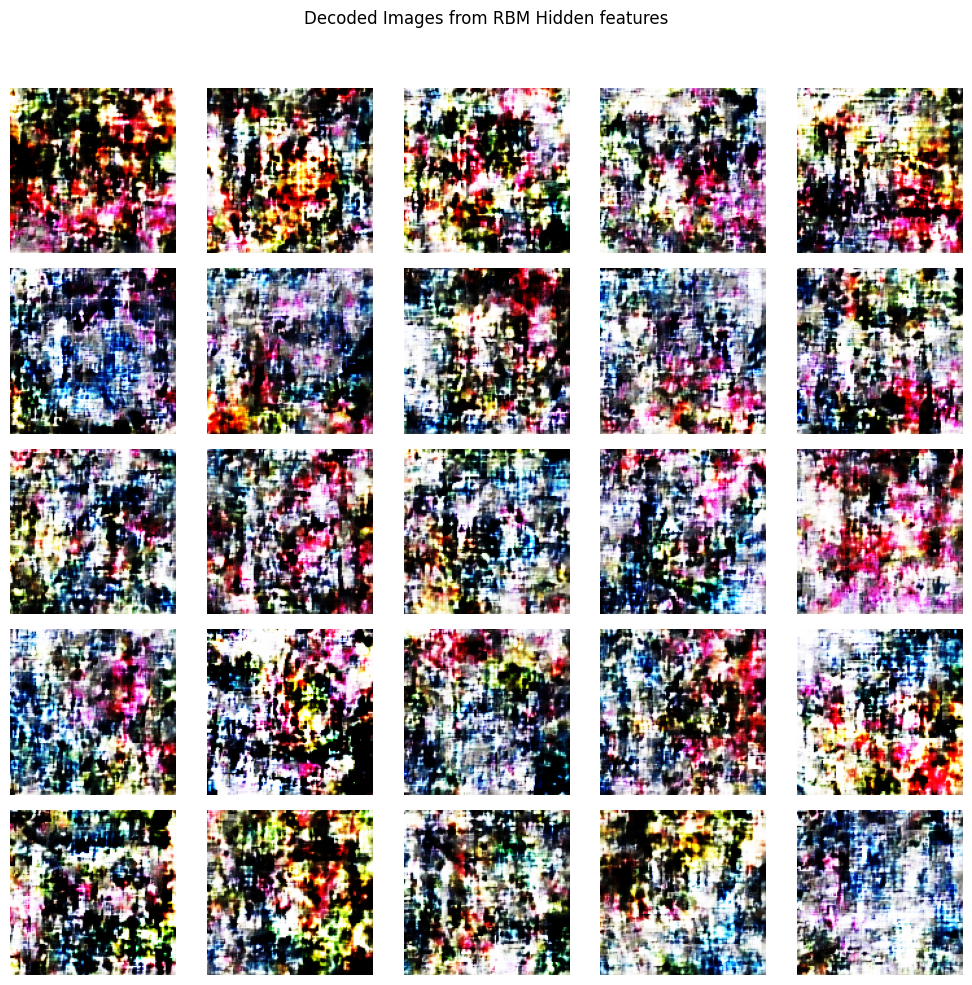

In [6]:
"""DECODE HIDDEN FEATURES in weight matrix W """

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)


# Load latent vectors and move to the right device

#rbm.W  visible neurons x hidden neurons 

weight_vectors = rbm.W.T # transpose hidden features x visible neurons 

latent_tensor = torch.from_numpy(weight_vectors).float().to(device)

autoencoder.eval()
decoded_images = []

with torch.no_grad():
    for i in range(0, len(latent_tensor), 32):
        batch = latent_tensor[i:i+32]
        decoded = autoencoder.decode(batch).cpu().numpy()  # decode still on GPU, then move to CPU
        decoded_images.extend(decoded)

# Convert to (N, H, W, C) for plotting
decoded_images = np.array(decoded_images).transpose(0, 2, 3, 1)

# Define grid size
Nx = 5  # Number of rows
Ny = 5  # Number of columns
total_images = Nx * Ny  # Total number of images to plot

# Ensure we don’t exceed the number of decoded images
num_images_to_plot = min(total_images, len(decoded_images))

# Plot decoded images in Nx x Ny grid
fig, axes = plt.subplots(Nx, Ny, figsize=(Ny * 2, Nx * 2))  # Adjust figure size based on grid
axes = axes.flatten()  # Flatten 2D array of axes for easier indexing

for i in range(num_images_to_plot):
    axes[i].imshow(decoded_images[i])
    axes[i].axis('off')

# Hide any unused axes if num_images_to_plot < total_images
for i in range(num_images_to_plot, total_images):
    axes[i].axis('off')

plt.suptitle("Decoded Images from RBM Hidden features")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title


plt.savefig("AE-RBMhiddenfeatures_" + filename + ".png", format="png", dpi=300)  # Save as PNG
plt.savefig("AE-RBMhiddenfeatures_" + filename + ".eps", format="eps")  # Save as PDF
plt.savefig("AE-RBMhiddenfeatures_" + filename + ".pdf", format="pdf")  # Save as PDF
plt.savefig("AE-RBMhiddenfeatures_" + filename + ".tiff", format="tiff", dpi=300)  # Save as TIFF

print("RBM hidden feature images saved")

plt.show()



In [ ]:
rbm.W.shape, latent_vectors.shape

In [ ]:
"""
to save a trained autoencoder
"""

# Save the model after training for later use
torch.save(autoencoder.state_dict(), 'autoencoder.pth')

print("trained model saved")

In [ ]:
"""
to load a saved trained autoencoder
"""

autoencoder = ConvAutoencoder(channels=3)  # Initialize the model
autoencoder.load_state_dict(torch.load('autoencoder.pth'))  # Load saved weights
autoencoder.eval()  # Set the model to evaluation mode for testing


print("trained model loaded")